In [61]:
#!/usr/bin/env python3
from opendbc.car.hyundai.values import CAR, HyundaiFlags
from opendbc.car.vehicle_model import VehicleModel
from opendbc.car.hyundai.carcontroller import get_max_angle_delta, get_max_angle, MAX_LATERAL_ACCEL, MAX_LATERAL_JERK
from opendbc.car.hyundai.interface import CarInterface
import math

def get_vm(car_name):
  return VehicleModel(CarInterface.get_non_essential_params(car_name))

def get_wheelbase(car_name):
    car_params = CarInterface.get_non_essential_params(car_name)
    return car_params.wheelbase


In [69]:
# Only platforms not in dashcam mode!
#PLATFORMS = {str(platform): platform for platform in CAR if
#             platform.config.flags & HyundaiFlags.CANFD_ANGLE_STEERING and not CarInterface.get_non_essential_params(str(platform)).dashcamOnly}


PLATFORMS = {str(platform): platform for platform in CAR if platform.config.flags & HyundaiFlags.CANFD_ANGLE_STEERING}

STEER_ANGLE_MAX = 180.
#BASELINE_CAR = "GENESIS_GV80_2025"
BASELINE_CAR = "HYUNDAI_IONIQ_5_PE"


In [70]:
PLATFORMS

{'HYUNDAI_IONIQ_5_PE': <CAR.HYUNDAI_IONIQ_5_PE>,
 'KIA_EV6_2025': <CAR.KIA_EV6_2025>,
 'KIA_EV9': <CAR.KIA_EV9>,
 'GENESIS_GV70_ELECTRIFIED_2ND_GEN': <CAR.GENESIS_GV70_ELECTRIFIED_2ND_GEN>,
 'GENESIS_GV80_2025': <CAR.GENESIS_GV80_2025>}

In [71]:
import numpy as np
import matplotlib.pyplot as plt

SPEEDS = np.linspace(1, 40, 200)

def get_steering_efficiency(steering_angle_deg):
    """
    Calculate steering efficiency: how much lateral acceleration per degree of steering.
    Higher efficiency = less steering input needed for same lateral acceleration.
    """
    return MAX_LATERAL_ACCEL / steering_angle_deg if steering_angle_deg != 0 else 0

def get_control_authority_ratio(current_angle, baseline_angle):
    """
    Calculate control authority ratio. 
    >1.0 means current car needs MORE steering than baseline (less efficient)
    <1.0 means current car needs LESS steering than baseline (more efficient)
    """
    return current_angle / baseline_angle if baseline_angle != 0 else 1.0

def compare_max_angle_plot(car_name, baseline_car, only_relevant_angles=True):
    """
    Plot steering angles and analyze steering efficiency & control authority differences.
    Focus on practical safety implications of model differences.
    """
    baseline_vm = get_vm(baseline_car)
    current_vm = get_vm(car_name)
    
    speeds = []
    baseline_angles = []
    current_angles = []
    steering_efficiency_current = []
    steering_efficiency_baseline = []
    control_authority_ratios = []
    
    for speed in SPEEDS:
        current_max = get_max_angle(speed, current_vm)
        baseline_max = get_max_angle(speed, baseline_vm)
        
        if only_relevant_angles and (current_max > STEER_ANGLE_MAX and baseline_max > STEER_ANGLE_MAX):
            continue
            
        speeds.append(speed)
        baseline_angles.append(baseline_max)
        current_angles.append(current_max)
        
        # Calculate steering efficiency (lat accel per degree)
        steering_efficiency_current.append(get_steering_efficiency(current_max))
        steering_efficiency_baseline.append(get_steering_efficiency(baseline_max))
        
        # Calculate control authority ratio
        control_authority_ratios.append(get_control_authority_ratio(current_max, baseline_max))
    
    # Create three subplots for comprehensive analysis
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20, 6))
    
    # Plot 1: Steering angles (original)
    ax1.plot(speeds, current_angles, label=f"{car_name}", color="blue", linewidth=2)
    ax1.plot(speeds, baseline_angles, label=f"{baseline_car} (baseline)", color="gray", linestyle="--", linewidth=2)
    ax1.set_title("Required Steering Angle vs Speed\n(for same lateral acceleration)")
    ax1.set_xlabel("Speed (m/s)")
    ax1.set_ylabel("Steering Angle (degrees)")
    ax1.grid(True)
    ax1.legend()
    
    # Plot 2: Steering efficiency
    ax2.plot(speeds, steering_efficiency_current, label=f"{car_name}", color="green", linewidth=2)
    ax2.plot(speeds, steering_efficiency_baseline, label=f"{baseline_car} (baseline)", color="gray", linestyle="--", linewidth=2)
    ax2.set_title("Steering Efficiency vs Speed\n(lateral accel per degree)")
    ax2.set_xlabel("Speed (m/s)")
    ax2.set_ylabel("Efficiency (m/s² per degree)")
    ax2.grid(True)
    ax2.legend()
    ax2.set_yscale('log')  # Log scale since efficiency varies dramatically
    
    # Plot 3: Control authority ratio
    ax3.axhline(y=1.0, color='red', linestyle=':', linewidth=2, label='Equal control (ratio = 1.0)')
    ax3.plot(speeds, control_authority_ratios, label=f"{car_name} vs {baseline_car}", color="purple", linewidth=2)
    ax3.fill_between(speeds, 1.0, control_authority_ratios, 
                    where=np.array(control_authority_ratios) > 1.0, alpha=0.3, color='red', 
                    label='Current needs MORE steering')
    ax3.fill_between(speeds, 1.0, control_authority_ratios, 
                    where=np.array(control_authority_ratios) < 1.0, alpha=0.3, color='green', 
                    label='Current needs LESS steering')
    ax3.set_title("Control Authority Ratio vs Speed\n(Current / Baseline steering requirement)")
    ax3.set_xlabel("Speed (m/s)")
    ax3.set_ylabel("Steering Ratio (Current/Baseline)")
    ax3.grid(True)
    ax3.legend()
    
    plt.tight_layout()
    plt.show()
    
    # Print detailed analysis table
    print(f"\n[STEERING EFFICIENCY & CONTROL AUTHORITY ANALYSIS]")
    print(f"{car_name} vs {baseline_car}")
    print(f"Target lateral acceleration: {MAX_LATERAL_ACCEL} m/s²")
    print(f"\n{'Speed':<8}{'Current':<10}{'Baseline':<10}{'Efficiency':<12}{'Base Eff':<12}{'Authority':<12}{'Interpretation':<20}")
    print(f"{'(m/s)':<8}{'Angle(°)':<10}{'Angle(°)':<10}{'(m/s²/°)':<12}{'(m/s²/°)':<12}{'Ratio':<12}{'':<20}")
    print("-" * 104)
    
    for speed in np.linspace(5, 40, 8):  # Fewer points for clarity
        baseline_angle = get_max_angle(speed, baseline_vm)
        current_angle = get_max_angle(speed, current_vm)
        
        if only_relevant_angles and current_angle > STEER_ANGLE_MAX:
            continue
            
        # Calculate metrics
        current_efficiency = get_steering_efficiency(current_angle)
        baseline_efficiency = get_steering_efficiency(baseline_angle)
        authority_ratio = get_control_authority_ratio(current_angle, baseline_angle)
        
        # Interpretation
        if authority_ratio > 1.1:
            interpretation = "Less responsive"
        elif authority_ratio < 0.9:
            interpretation = "More responsive"
        else:
            interpretation = "Similar"
        
        print(f"{speed:<8.1f}{current_angle:<10.1f}{baseline_angle:<10.1f}"
              f"{current_efficiency:<12.4f}{baseline_efficiency:<12.4f}"
              f"{authority_ratio:<12.2f}{interpretation:<20}")
    
    # Summary statistics
    avg_authority_ratio = np.mean(control_authority_ratios)
    max_authority_ratio = np.max(control_authority_ratios)
    min_authority_ratio = np.min(control_authority_ratios)
    
    print(f"\n[SUMMARY STATISTICS]")
    print(f"Average control authority ratio: {avg_authority_ratio:.3f}")
    print(f"Range: {min_authority_ratio:.3f} to {max_authority_ratio:.3f}")
    
    if avg_authority_ratio > 1.05:
        print(f"⚠️  {car_name} generally requires MORE steering input than {baseline_car}")
        print(f"   → Potential safety concern: reduced control authority")
    elif avg_authority_ratio < 0.95:
        print(f"✅ {car_name} generally requires LESS steering input than {baseline_car}")
        print(f"   → Better control authority and responsiveness")
    else:
        print(f"✅ {car_name} has similar steering requirements to {baseline_car}")
    
    return {
        'speeds': speeds,
        'current_angles': current_angles,
        'baseline_angles': baseline_angles,
        'authority_ratios': control_authority_ratios,
        'avg_authority_ratio': avg_authority_ratio
    }

def compare_max_angle_delta_plot(car_name, baseline_car="HYUNDAI_IONIQ_5_PE"):
    """
    Analyze steering rate capabilities and responsiveness differences.
    """
    baseline_vm = get_vm(baseline_car)
    current_vm = get_vm(car_name)
    
    speeds = []
    baseline_deltas = []
    current_deltas = []
    delta_ratios = []
    
    for speed in SPEEDS:
        speeds.append(speed)
        
        current_delta = get_max_angle_delta(speed, current_vm)
        baseline_delta = get_max_angle_delta(speed, baseline_vm)
        
        baseline_deltas.append(baseline_delta)
        current_deltas.append(current_delta)
        
        # Calculate steering rate ratio
        delta_ratio = current_delta / baseline_delta if baseline_delta != 0 else 1.0
        delta_ratios.append(delta_ratio)
    
    # Create subplots
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))
    
    # Plot 1: Steering angle deltas
    ax1.plot(speeds, current_deltas, label=f"{car_name}", color="green", linewidth=2)
    ax1.plot(speeds, baseline_deltas, label=f"{baseline_car} (baseline)", color="gray", linestyle="--", linewidth=2)
    ax1.set_title("Max Steering Rate vs Speed")
    ax1.set_xlabel("Speed (m/s)")
    ax1.set_ylabel("Max Steering Rate (deg/frame)")
    ax1.grid(True)
    ax1.legend()
    
    # Plot 2: Steering rate ratio
    ax2.axhline(y=1.0, color='red', linestyle=':', linewidth=2, label='Equal rate capability')
    ax2.plot(speeds, delta_ratios, label=f"{car_name} vs {baseline_car}", color="orange", linewidth=2)
    ax2.fill_between(speeds, 1.0, delta_ratios, 
                    where=np.array(delta_ratios) > 1.0, alpha=0.3, color='green', 
                    label='Current has HIGHER rate capability')
    ax2.fill_between(speeds, 1.0, delta_ratios, 
                    where=np.array(delta_ratios) < 1.0, alpha=0.3, color='red', 
                    label='Current has LOWER rate capability')
    ax2.set_title("Steering Rate Capability Ratio vs Speed\n(Current / Baseline)")
    ax2.set_xlabel("Speed (m/s)")
    ax2.set_ylabel("Rate Ratio (Current/Baseline)")
    ax2.grid(True)
    ax2.legend()
    
    plt.tight_layout()
    plt.show()
    
    # Print analysis table
    print(f"\n[STEERING RATE ANALYSIS] {car_name} vs {baseline_car}")
    print(f"Target lateral jerk: {MAX_LATERAL_JERK} m/s³")
    print(f"\n{'Speed':<8}{'Current':<12}{'Baseline':<12}{'Rate Ratio':<12}{'Responsiveness':<15}")
    print(f"{'(m/s)':<8}{'Rate(°/f)':<12}{'Rate(°/f)':<12}{'(C/B)':<12}{'':<15}")
    print("-" * 67)
    
    for speed in np.linspace(5, 40, 8):
        baseline_delta = get_max_angle_delta(speed, baseline_vm)
        current_delta = get_max_angle_delta(speed, current_vm)
        rate_ratio = current_delta / baseline_delta if baseline_delta != 0 else 1.0
        
        if rate_ratio > 1.1:
            responsiveness = "More responsive"
        elif rate_ratio < 0.9:
            responsiveness = "Less responsive"
        else:
            responsiveness = "Similar"
        
        print(f"{speed:<8.1f}{current_delta:<12.4f}{baseline_delta:<12.4f}"
              f"{rate_ratio:<12.2f}{responsiveness:<15}")
    
    avg_rate_ratio = np.mean(delta_ratios)
    print(f"\nAverage steering rate ratio: {avg_rate_ratio:.3f}")
    
    if avg_rate_ratio > 1.05:
        print(f"✅ {car_name} has HIGHER steering rate capability than {baseline_car}")
        print(f"   → Better emergency maneuver capability")
    elif avg_rate_ratio < 0.95:
        print(f"⚠️  {car_name} has LOWER steering rate capability than {baseline_car}")
        print(f"   → Reduced emergency maneuver capability")
    else:
        print(f"✅ {car_name} has similar steering rate capability to {baseline_car}")

def safety_summary(car_name, baseline_car, analysis_results):
    """
    Provide overall safety assessment based on steering analysis.
    """
    avg_ratio = analysis_results['avg_authority_ratio']
    
    print(f"\n{'='*60}")
    print(f"OVERALL SAFETY ASSESSMENT: {car_name} vs {baseline_car}")
    print(f"{'='*60}")
    
    if avg_ratio > 1.2:
        print(f"🔴 HIGH CONCERN: {car_name} requires {((avg_ratio-1)*100):.1f}% more steering")
        print(f"   • Significant reduction in control authority")
        print(f"   • May feel sluggish or unresponsive")
        print(f"   • Consider model parameter review")
    elif avg_ratio > 1.05:
        print(f"🟡 MODERATE CONCERN: {car_name} requires {((avg_ratio-1)*100):.1f}% more steering")
        print(f"   • Slight reduction in control authority")
        print(f"   • Monitor for user feedback on responsiveness")
    elif avg_ratio < 0.8:
        print(f"🟡 REVIEW NEEDED: {car_name} requires {((1-avg_ratio)*100):.1f}% less steering")
        print(f"   • Higher sensitivity - could feel twitchy")
        print(f"   • Verify this matches real vehicle behavior")
    else:
        print(f"✅ GOOD: Similar control characteristics")
        print(f"   • Steering requirements within 5% of baseline")
        print(f"   • Expected to have similar feel and safety")

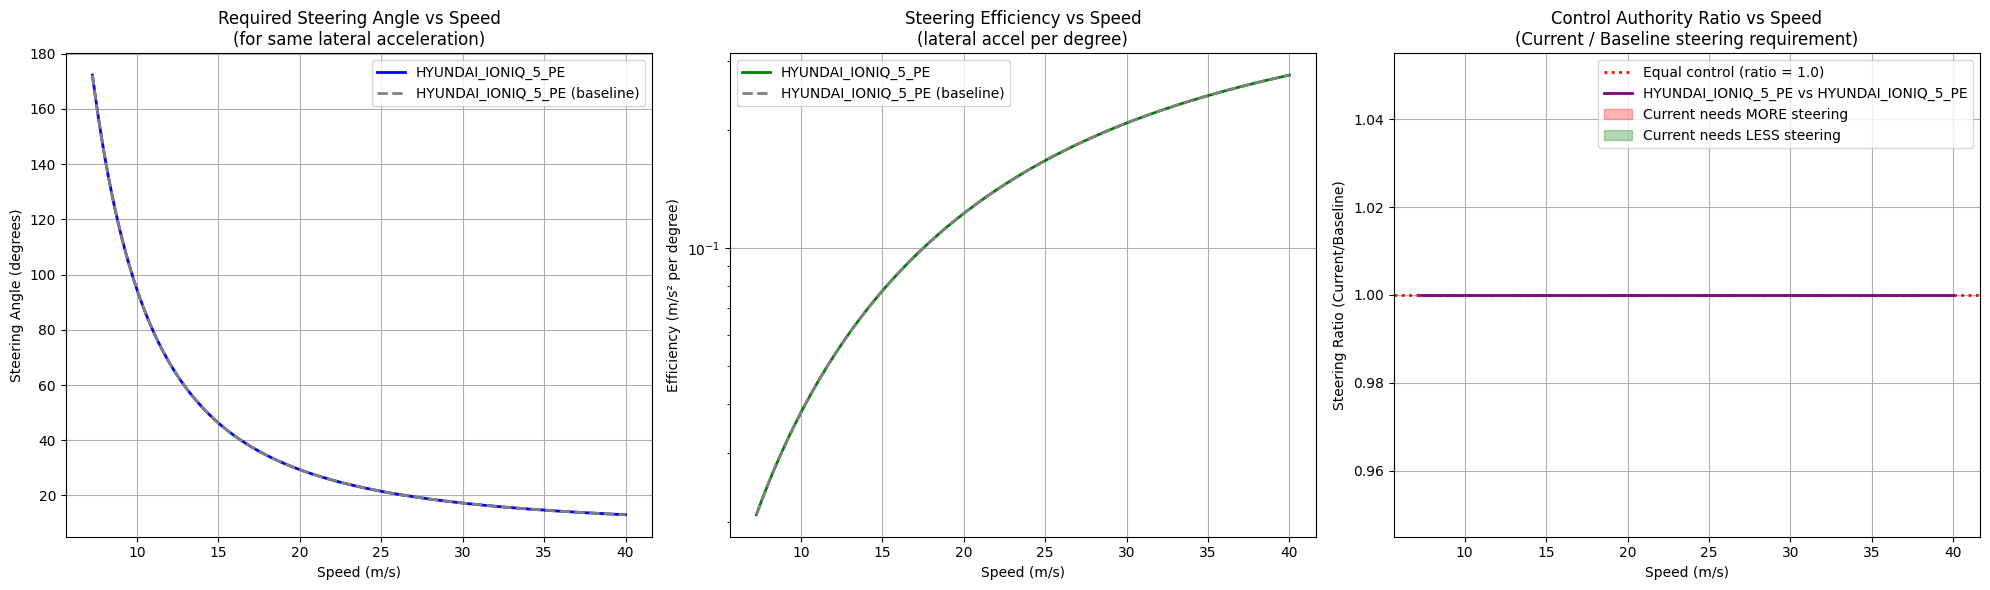


[STEERING EFFICIENCY & CONTROL AUTHORITY ANALYSIS]
HYUNDAI_IONIQ_5_PE vs HYUNDAI_IONIQ_5_PE
Target lateral acceleration: 3.5886 m/s²

Speed   Current   Baseline  Efficiency  Base Eff    Authority   Interpretation      
(m/s)   Angle(°)  Angle(°)  (m/s²/°)    (m/s²/°)    Ratio                           
--------------------------------------------------------------------------------------------------------
10.0    94.6      94.6      0.0379      0.0379      1.00        Similar             
15.0    46.3      46.3      0.0776      0.0776      1.00        Similar             
20.0    29.3      29.3      0.1223      0.1223      1.00        Similar             
25.0    21.5      21.5      0.1669      0.1669      1.00        Similar             
30.0    17.2      17.2      0.2081      0.2081      1.00        Similar             
35.0    14.7      14.7      0.2445      0.2445      1.00        Similar             
40.0    13.0      13.0      0.2759      0.2759      1.00        Similar         

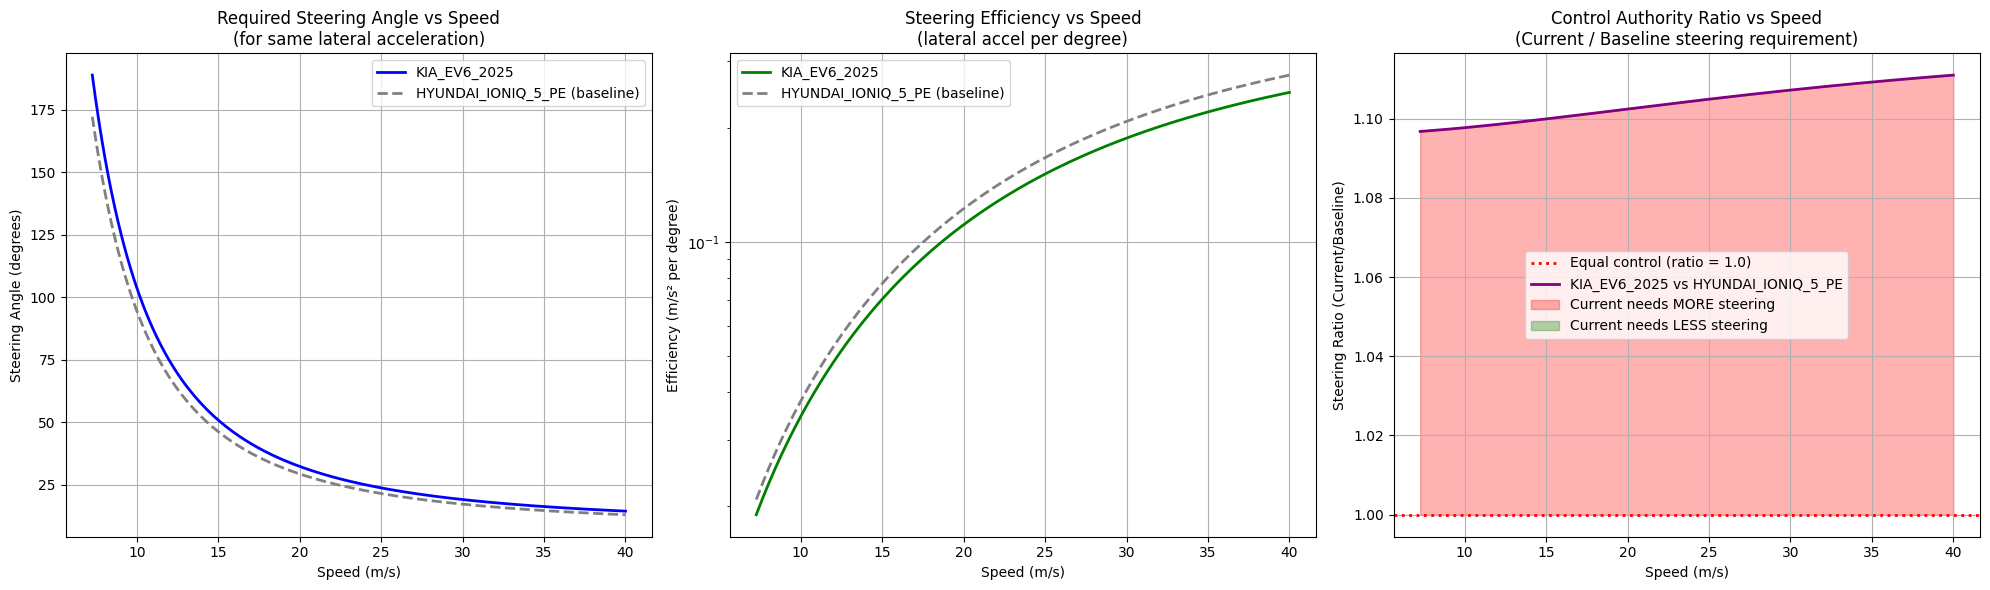


[STEERING EFFICIENCY & CONTROL AUTHORITY ANALYSIS]
KIA_EV6_2025 vs HYUNDAI_IONIQ_5_PE
Target lateral acceleration: 3.5886 m/s²

Speed   Current   Baseline  Efficiency  Base Eff    Authority   Interpretation      
(m/s)   Angle(°)  Angle(°)  (m/s²/°)    (m/s²/°)    Ratio                           
--------------------------------------------------------------------------------------------------------
10.0    103.9     94.6      0.0345      0.0379      1.10        Similar             
15.0    50.9      46.3      0.0705      0.0776      1.10        Similar             
20.0    32.3      29.3      0.1110      0.1223      1.10        Less responsive     
25.0    23.8      21.5      0.1511      0.1669      1.10        Less responsive     
30.0    19.1      17.2      0.1880      0.2081      1.11        Less responsive     
35.0    16.3      14.7      0.2205      0.2445      1.11        Less responsive     
40.0    14.5      13.0      0.2483      0.2759      1.11        Less responsive     



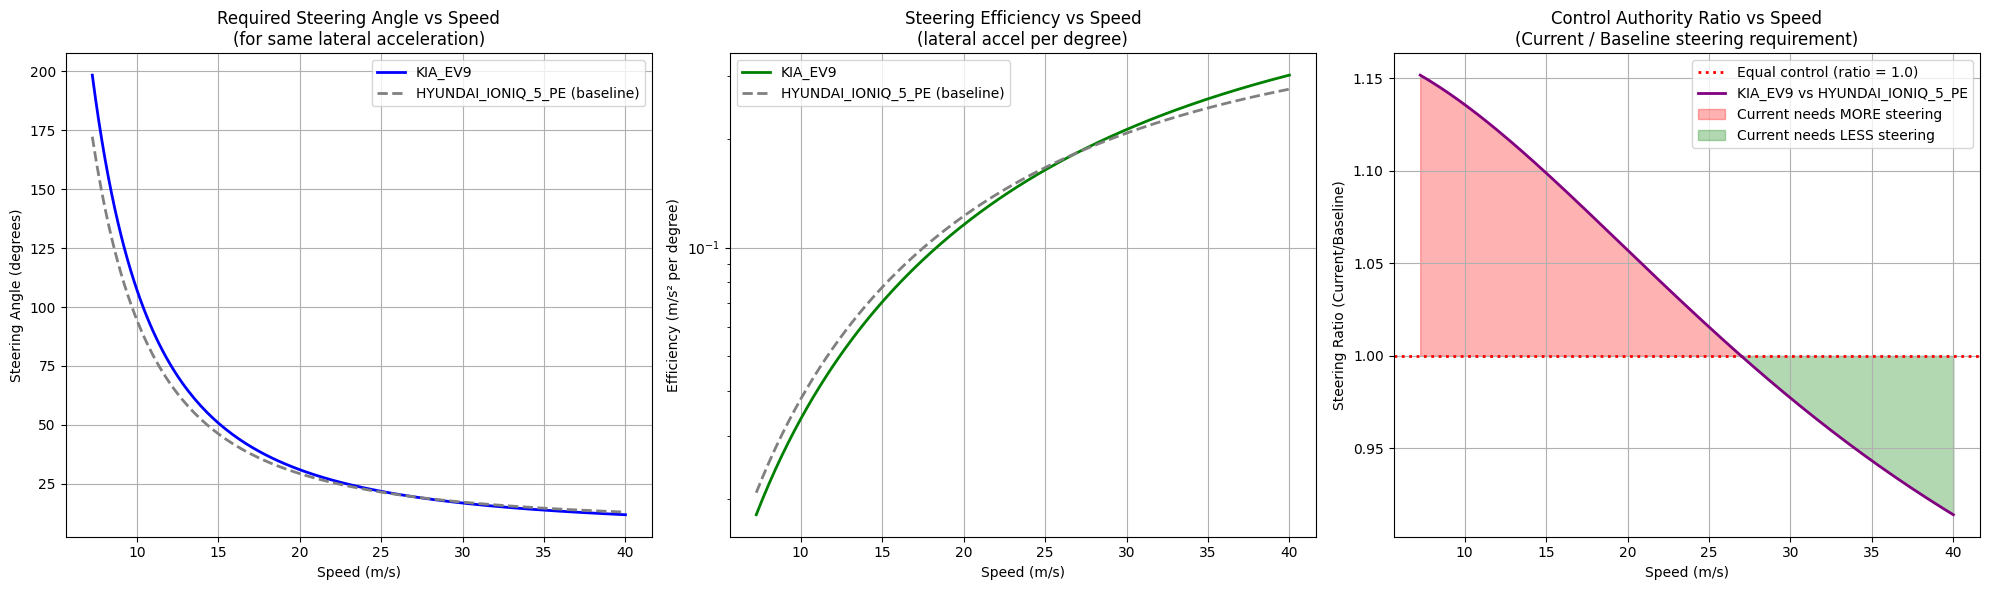


[STEERING EFFICIENCY & CONTROL AUTHORITY ANALYSIS]
KIA_EV9 vs HYUNDAI_IONIQ_5_PE
Target lateral acceleration: 3.5886 m/s²

Speed   Current   Baseline  Efficiency  Base Eff    Authority   Interpretation      
(m/s)   Angle(°)  Angle(°)  (m/s²/°)    (m/s²/°)    Ratio                           
--------------------------------------------------------------------------------------------------------
10.0    107.5     94.6      0.0334      0.0379      1.14        Less responsive     
15.0    50.8      46.3      0.0706      0.0776      1.10        Similar             
20.0    31.0      29.3      0.1157      0.1223      1.06        Similar             
25.0    21.8      21.5      0.1643      0.1669      1.02        Similar             
30.0    16.8      17.2      0.2130      0.2081      0.98        Similar             
35.0    13.8      14.7      0.2592      0.2445      0.94        Similar             
40.0    11.9      13.0      0.3018      0.2759      0.91        Similar             

[SUMM

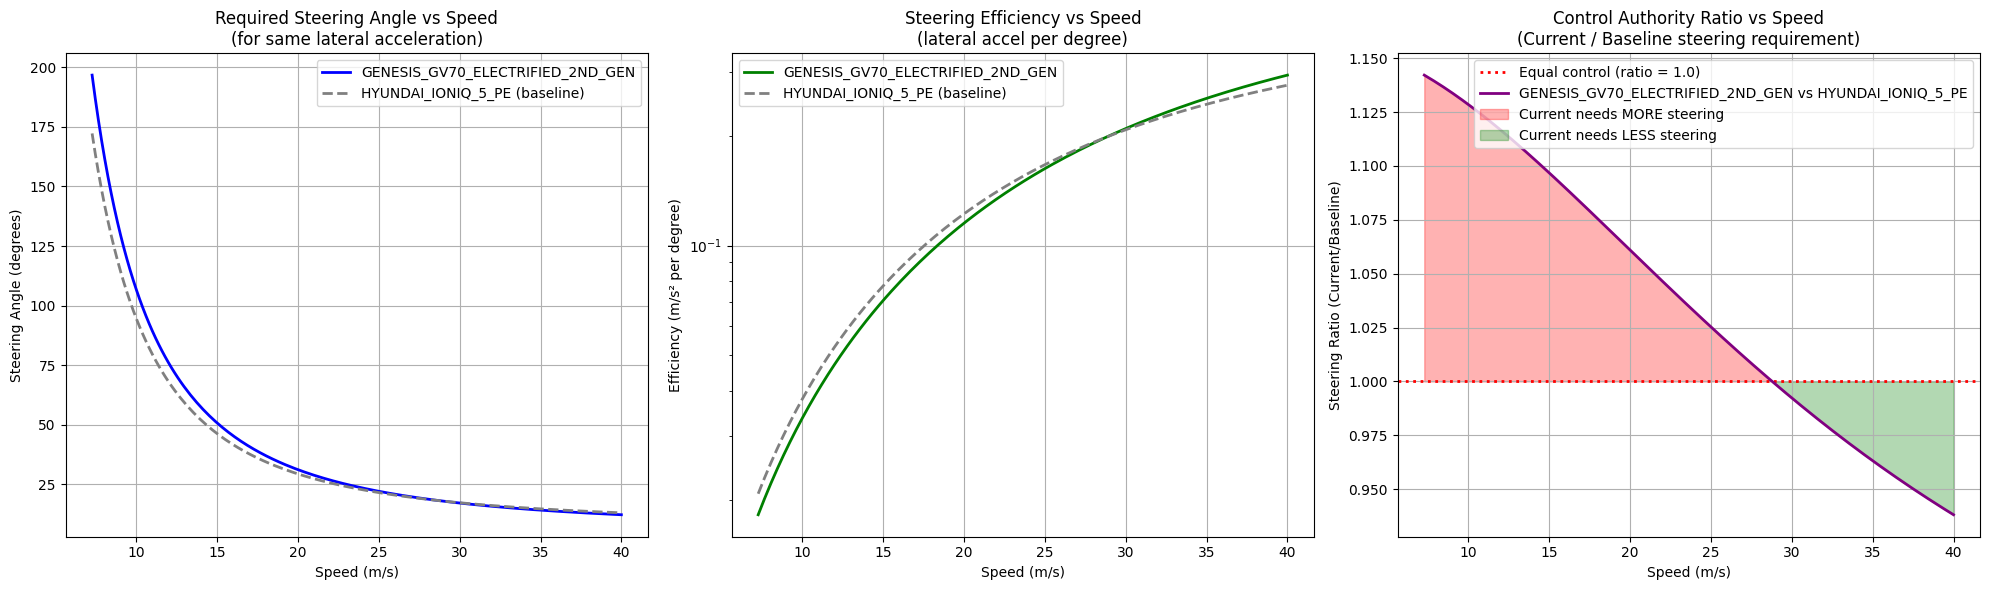


[STEERING EFFICIENCY & CONTROL AUTHORITY ANALYSIS]
GENESIS_GV70_ELECTRIFIED_2ND_GEN vs HYUNDAI_IONIQ_5_PE
Target lateral acceleration: 3.5886 m/s²

Speed   Current   Baseline  Efficiency  Base Eff    Authority   Interpretation      
(m/s)   Angle(°)  Angle(°)  (m/s²/°)    (m/s²/°)    Ratio                           
--------------------------------------------------------------------------------------------------------
10.0    106.8     94.6      0.0336      0.0379      1.13        Less responsive     
15.0    50.7      46.3      0.0707      0.0776      1.10        Similar             
20.0    31.1      29.3      0.1153      0.1223      1.06        Similar             
25.0    22.0      21.5      0.1628      0.1669      1.03        Similar             
30.0    17.1      17.2      0.2097      0.2081      0.99        Similar             
35.0    14.1      14.7      0.2539      0.2445      0.96        Similar             
40.0    12.2      13.0      0.2941      0.2759      0.94        Si

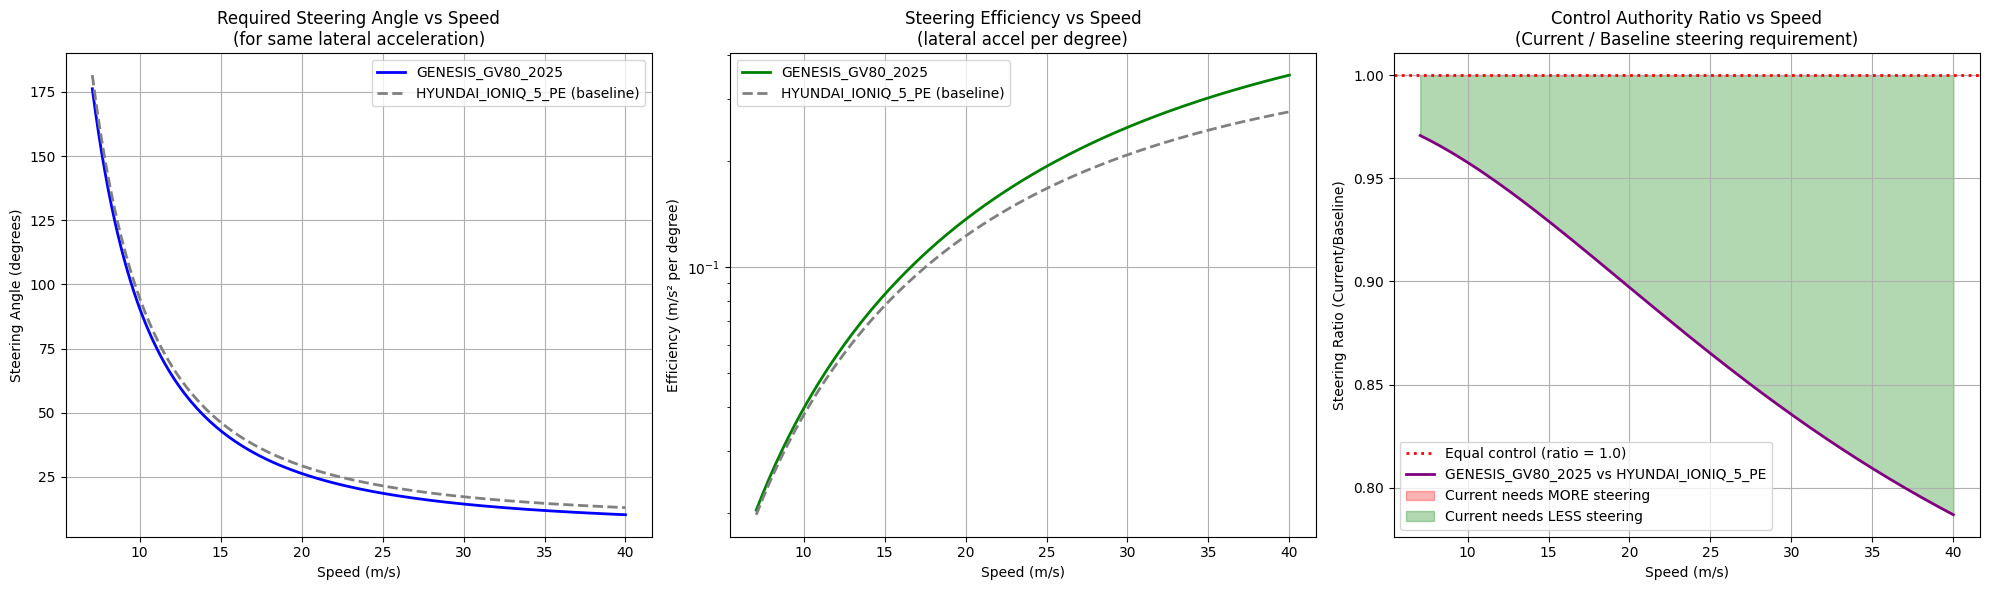


[STEERING EFFICIENCY & CONTROL AUTHORITY ANALYSIS]
GENESIS_GV80_2025 vs HYUNDAI_IONIQ_5_PE
Target lateral acceleration: 3.5886 m/s²

Speed   Current   Baseline  Efficiency  Base Eff    Authority   Interpretation      
(m/s)   Angle(°)  Angle(°)  (m/s²/°)    (m/s²/°)    Ratio                           
--------------------------------------------------------------------------------------------------------
10.0    90.6      94.6      0.0396      0.0379      0.96        Similar             
15.0    43.0      46.3      0.0835      0.0776      0.93        Similar             
20.0    26.3      29.3      0.1364      0.1223      0.90        More responsive     
25.0    18.6      21.5      0.1929      0.1669      0.87        More responsive     
30.0    14.4      17.2      0.2491      0.2081      0.84        More responsive     
35.0    11.9      14.7      0.3021      0.2445      0.81        More responsive     
40.0    10.2      13.0      0.3506      0.2759      0.79        More responsive  

In [72]:
for car_name in PLATFORMS:
    compare_max_angle_plot(car_name, BASELINE_CAR, True)
    print("-"*120)
print(f"Comparison complete across {len(PLATFORMS)} Hyundai models with CANFD angle steering support.")

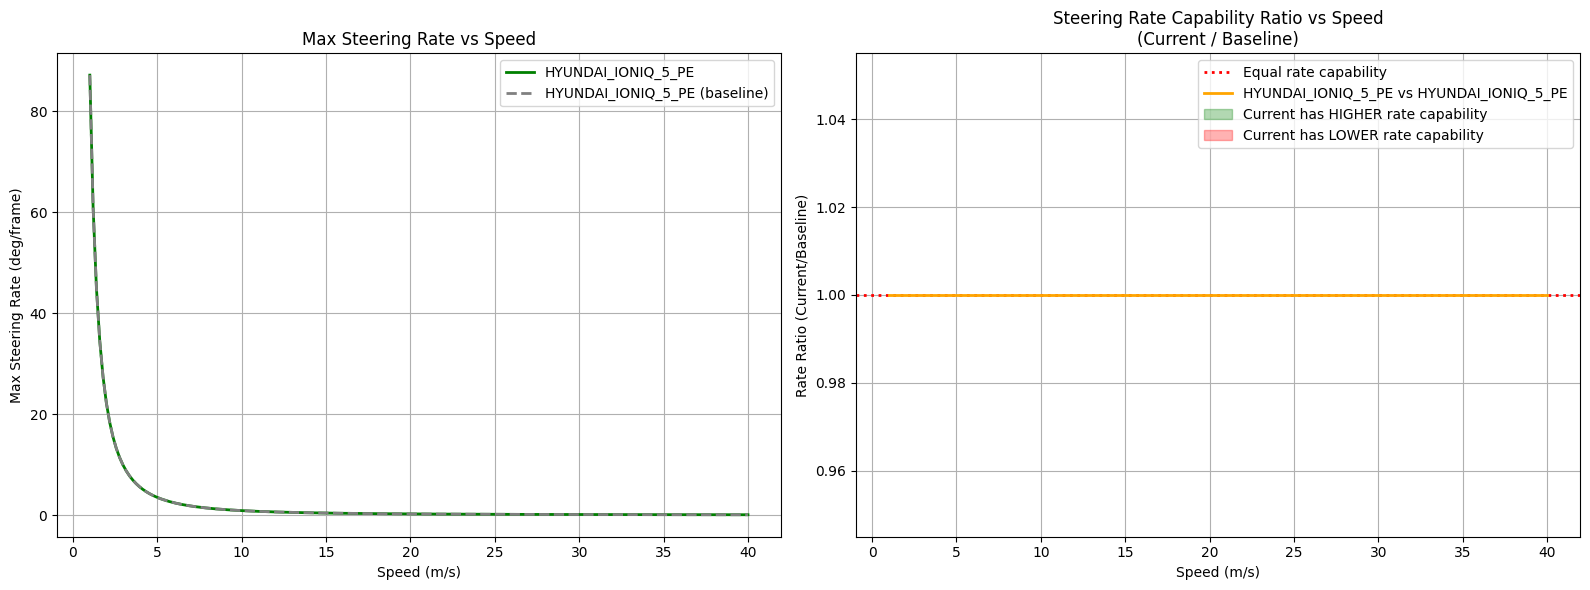


[STEERING RATE ANALYSIS] HYUNDAI_IONIQ_5_PE vs HYUNDAI_IONIQ_5_PE
Target lateral jerk: 3.5886 m/s³

Speed   Current     Baseline    Rate Ratio  Responsiveness 
(m/s)   Rate(°/f)   Rate(°/f)   (C/B)                      
-------------------------------------------------------------------
5.0     3.5589      3.5589      1.00        Similar        
10.0    0.9465      0.9465      1.00        Similar        
15.0    0.4627      0.4627      1.00        Similar        
20.0    0.2934      0.2934      1.00        Similar        
25.0    0.2150      0.2150      1.00        Similar        
30.0    0.1724      0.1724      1.00        Similar        
35.0    0.1467      0.1467      1.00        Similar        
40.0    0.1301      0.1301      1.00        Similar        

Average steering rate ratio: 1.000
✅ HYUNDAI_IONIQ_5_PE has similar steering rate capability to HYUNDAI_IONIQ_5_PE


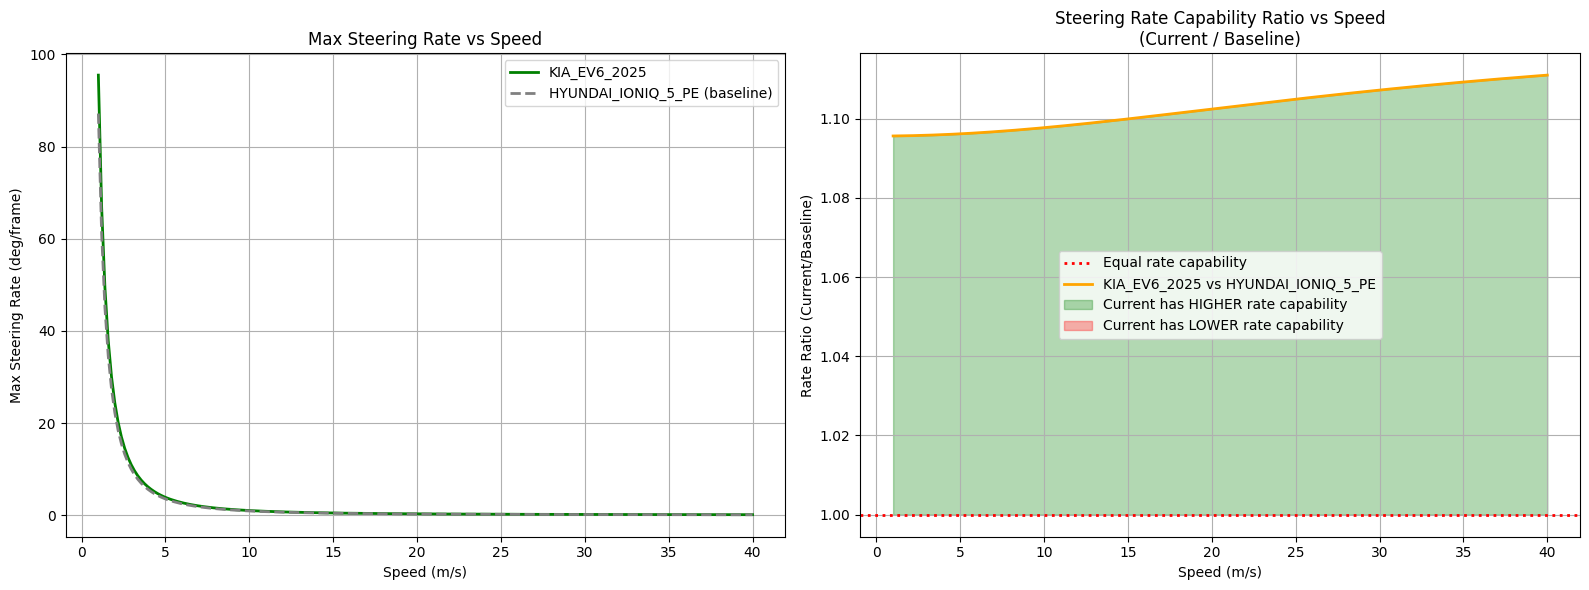


[STEERING RATE ANALYSIS] KIA_EV6_2025 vs HYUNDAI_IONIQ_5_PE
Target lateral jerk: 3.5886 m/s³

Speed   Current     Baseline    Rate Ratio  Responsiveness 
(m/s)   Rate(°/f)   Rate(°/f)   (C/B)                      
-------------------------------------------------------------------
5.0     3.9010      3.5589      1.10        Similar        
10.0    1.0389      0.9465      1.10        Similar        
15.0    0.5089      0.4627      1.10        Similar        
20.0    0.3234      0.2934      1.10        More responsive
25.0    0.2375      0.2150      1.10        More responsive
30.0    0.1909      0.1724      1.11        More responsive
35.0    0.1628      0.1467      1.11        More responsive
40.0    0.1445      0.1301      1.11        More responsive

Average steering rate ratio: 1.103
✅ KIA_EV6_2025 has HIGHER steering rate capability than HYUNDAI_IONIQ_5_PE
   → Better emergency maneuver capability


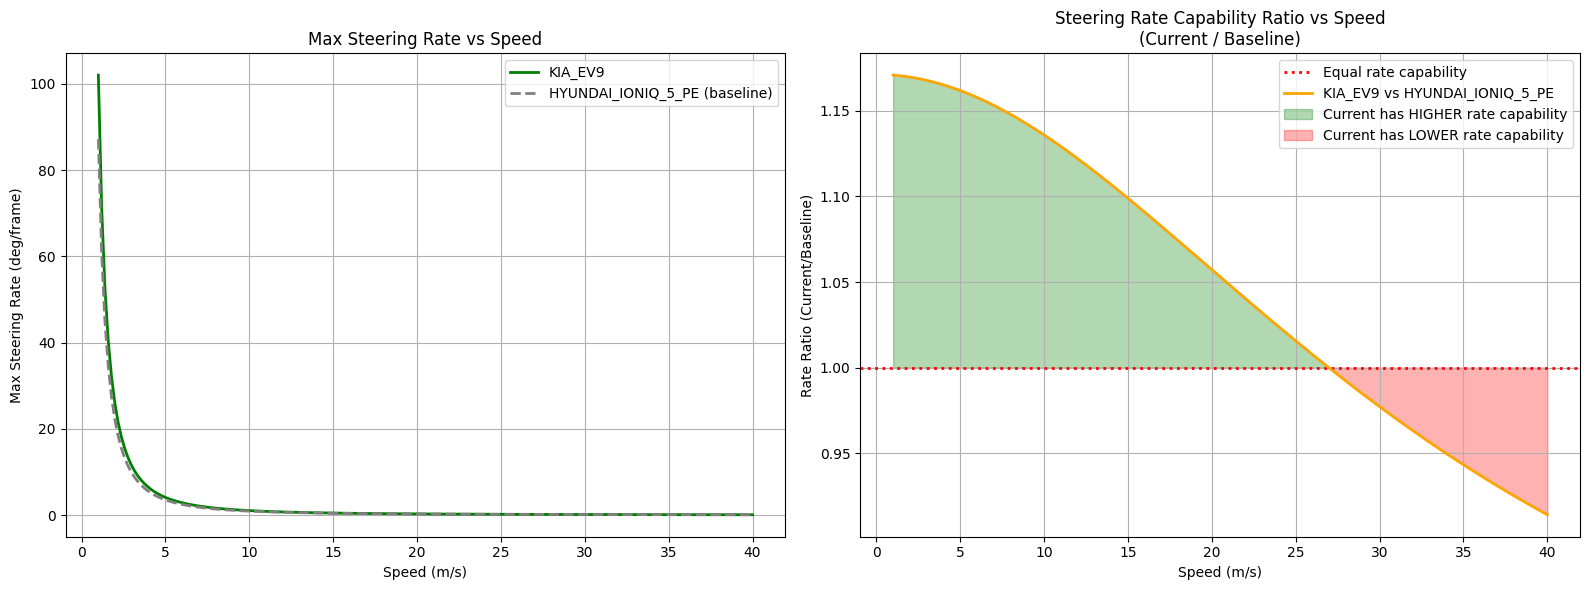


[STEERING RATE ANALYSIS] KIA_EV9 vs HYUNDAI_IONIQ_5_PE
Target lateral jerk: 3.5886 m/s³

Speed   Current     Baseline    Rate Ratio  Responsiveness 
(m/s)   Rate(°/f)   Rate(°/f)   (C/B)                      
-------------------------------------------------------------------
5.0     4.1345      3.5589      1.16        More responsive
10.0    1.0750      0.9465      1.14        More responsive
15.0    0.5084      0.4627      1.10        Similar        
20.0    0.3101      0.2934      1.06        Similar        
25.0    0.2184      0.2150      1.02        Similar        
30.0    0.1685      0.1724      0.98        Similar        
35.0    0.1384      0.1467      0.94        Similar        
40.0    0.1189      0.1301      0.91        Similar        

Average steering rate ratio: 1.051
✅ KIA_EV9 has HIGHER steering rate capability than HYUNDAI_IONIQ_5_PE
   → Better emergency maneuver capability


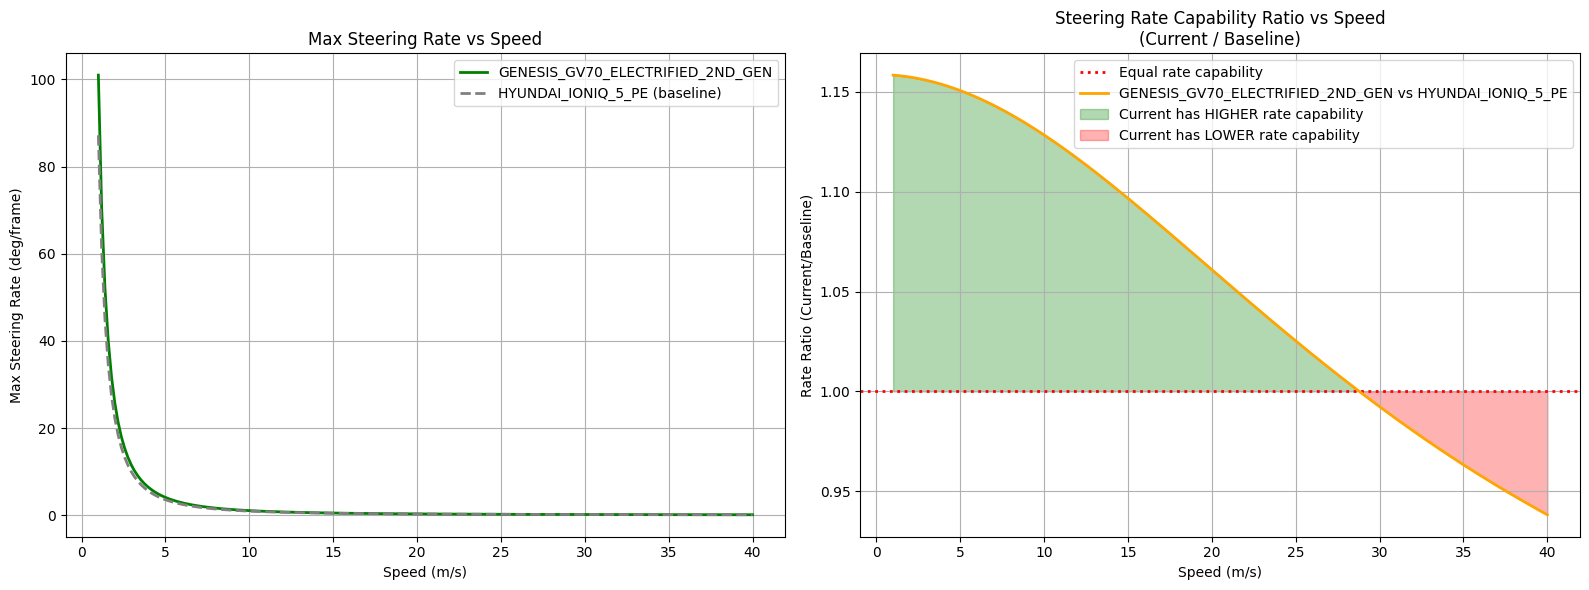


[STEERING RATE ANALYSIS] GENESIS_GV70_ELECTRIFIED_2ND_GEN vs HYUNDAI_IONIQ_5_PE
Target lateral jerk: 3.5886 m/s³

Speed   Current     Baseline    Rate Ratio  Responsiveness 
(m/s)   Rate(°/f)   Rate(°/f)   (C/B)                      
-------------------------------------------------------------------
5.0     4.0953      3.5589      1.15        More responsive
10.0    1.0681      0.9465      1.13        More responsive
15.0    0.5075      0.4627      1.10        Similar        
20.0    0.3112      0.2934      1.06        Similar        
25.0    0.2204      0.2150      1.03        Similar        
30.0    0.1711      0.1724      0.99        Similar        
35.0    0.1413      0.1467      0.96        Similar        
40.0    0.1220      0.1301      0.94        Similar        

Average steering rate ratio: 1.056
✅ GENESIS_GV70_ELECTRIFIED_2ND_GEN has HIGHER steering rate capability than HYUNDAI_IONIQ_5_PE
   → Better emergency maneuver capability


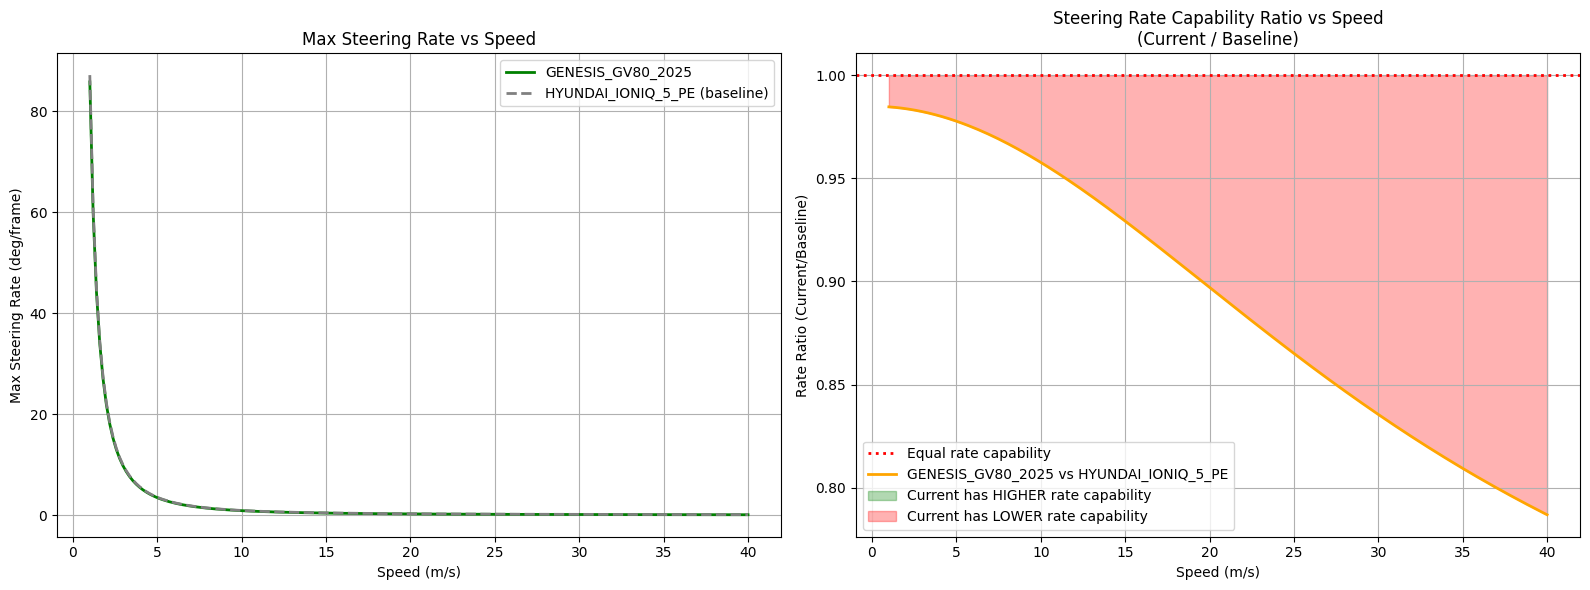


[STEERING RATE ANALYSIS] GENESIS_GV80_2025 vs HYUNDAI_IONIQ_5_PE
Target lateral jerk: 3.5886 m/s³

Speed   Current     Baseline    Rate Ratio  Responsiveness 
(m/s)   Rate(°/f)   Rate(°/f)   (C/B)                      
-------------------------------------------------------------------
5.0     3.4794      3.5589      0.98        Similar        
10.0    0.9064      0.9465      0.96        Similar        
15.0    0.4300      0.4627      0.93        Similar        
20.0    0.2632      0.2934      0.90        Less responsive
25.0    0.1860      0.2150      0.87        Less responsive
30.0    0.1441      0.1724      0.84        Less responsive
35.0    0.1188      0.1467      0.81        Less responsive
40.0    0.1024      0.1301      0.79        Less responsive

Average steering rate ratio: 0.893
⚠️  GENESIS_GV80_2025 has LOWER steering rate capability than HYUNDAI_IONIQ_5_PE
   → Reduced emergency maneuver capability
Comparison complete across 5 Hyundai models with CANFD angle steering su

In [73]:
for car_name in PLATFORMS:
    compare_max_angle_delta_plot(car_name, BASELINE_CAR)
print(f"Comparison complete across {len(PLATFORMS)} Hyundai models with CANFD angle steering support.")